In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%cd /content/drive/MyDrive/PHI/ToF_ML/src

/content/drive/MyDrive/PHI/ToF_ML/src


In [3]:
from ast import literal_eval
df = pd.read_csv('../data/full_corrected_dataset_with_techs.csv')
df['channels'] = df['channels'].apply(literal_eval)
df['intensities'] = df['intensities'].apply(literal_eval)
df['masses'] = df['masses'].apply(literal_eval)

In [4]:
from data_transformation import get_frags
frags = get_frags()['FragmentMass']
positives = [0 for x in range(len(frags))]
negatives = [0 for x in range(len(frags))]
tech_list = [negatives, positives]

In [5]:
from data_transformation import get_frags_dists
for row in df.itertuples():
    masses, fragments, distances = get_frags_dists(row.masses, frags, threshes=[0.003])
    for frag in fragments:
        ind = frags[frags == frag].index
        if len(ind) == 1:
            tech_list[row.technique][ind[0]] += 1

In [6]:
negatives = np.array(negatives)
positives = np.array(positives)
fragment_df = get_frags()
fragment_df['occurrences'] = positives + negatives
fragment_df['negative_occurence_rate'] = negatives / (negatives + positives + .001)
fragment_df['positive_occurence_rate'] = positives / (negatives + positives + .001)

In [7]:
fragment_df.to_csv('../data/fragment_data_with_pos_neg_occurrences.csv', index=False)

In [8]:
test = get_frags()
test[test['FragmentLabel']=='S']

,FragmentMass,FragmentLabel,Isotopes,Formula,FragmentID
65,31.97210,S,32S1,S,66
70,32.97146,S,33S1,33S,71
73,33.96790,S,34S1,34S,74
76,0.00000,S,36S1,36S,77


In [9]:
fragment_df[fragment_df['negative_occurence_rate'] == 0]

,FragmentMass,FragmentLabel,Isotopes,Formula,FragmentID,occurrences,negative_occurence_rate,positive_occurence_rate
3,4.002603,He,4He1,He,4,0,0.0,0.000000
76,0.000000,S,36S1,36S,77,0,0.0,0.000000
327,66.927100,Zn,67Zn1,67Zn,328,0,0.0,0.000000
474,76.919900,Se,77Se1,77Se,475,12,0.0,0.999917
624,86.908900,Sr,87Sr1,87Sr,625,7,0.0,0.999857
...,...,...,...,...,...,...,...,...
4427,201.207780,C10H25N4,12C10 1H25 14N4,C10+H25+N4,4428,4,0.0,0.999750
4428,201.209110,C12H27NO,12C12 1H27 14N1 16O1,C12+H27+N+O,4429,3,0.0,0.999667
4429,201.220350,C11H27N3,12C11 1H27 14N3,C11+H27+N3,4430,1,0.0,0.999001
4446,202.120360,C10H18O4,12C10 1H18 16O4,C10+H18+O4,4447,3,0.0,0.999667


In [10]:
fragment_df[fragment_df['occurrences'] <= 10]

,FragmentMass,FragmentLabel,Isotopes,Formula,FragmentID,occurrences,negative_occurence_rate,positive_occurence_rate
3,4.002603,He,4He1,He,4,0,0.000000,0.000000
6,9.012180,Be,9Be1,Be,7,6,0.166639,0.833194
29,21.991380,Ne,22Ne1,22Ne,30,8,0.624922,0.374953
76,0.000000,S,36S1,36S,77,0,0.000000,0.000000
327,66.927100,Zn,67Zn1,67Zn,328,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
4456,202.191790,C10H24N3O,12C10 1H24 14N3 16O1,C10+H24+N3+O,4457,6,0.499917,0.499917
4457,202.193120,C12H26O2,12C12 1H26 16O2,C12+H26+O2,4458,5,0.599880,0.399920
4458,202.204360,C11H26N2O,12C11 1H26 14N2 16O1,C11+H26+N2+O,4459,7,0.285673,0.714184
4459,202.215600,C10H26N4,12C10 1H26 14N4,C10+H26+N4,4460,3,0.333222,0.666445


In [11]:
fragment_df[fragment_df['FragmentLabel']=='O']

,FragmentMass,FragmentLabel,Isotopes,Formula,FragmentID,occurrences,negative_occurence_rate,positive_occurence_rate
17,15.99490,O,16O1,O,18,1431,0.753319,0.246680
20,16.99913,O,17O1,17O,21,182,0.747249,0.252746
23,17.99916,O,18O1,18O,24,856,0.911214,0.088785


In [12]:
df.head()

,file_name,MassOverTime,MassOffset,StartFlightTime,SpecBinSize,channels,intensities,masses,adjusted_original_proportion_identified,avg_dist_frags_low,avg_dist_frags_high,adjusted_proportion_identified,proportion_identified,diff,prop_diff_in_low,calibration,technique
0,C0059-V1.csv,1.690970,0.708925,0.0,0.128,"[12729.6134, 13388.07292, 14021.38724, 14625.2...","[10106.0, 32018.0, 4303.0, 816.0, 44497.0, 346...","[12.000516134304917, 13.00825496659651, 14.015...",0.307692,0.000930,0.001400,0.538462,0.515789,0.000470,0.504991,0,0
1,C0060-V1.csv,1.686650,0.706374,0.0,0.128,"[12773.45818, 13433.49441, 13495.05187, 14068....","[37242.0, 67973.0, 112.0, 5361.0, 4489.0, 2193...","[11.999648578820876, 13.007180420340381, 13.10...",0.409091,0.000994,0.001364,0.562937,0.542088,0.000370,0.372432,1,0
2,C0061-U1.csv,1.684820,0.708105,0.0,0.128,"[12779.34033, 13440.22492, 14076.03163, 14689....","[483.0, 782.0, 1374.0, 2985.0, 152.0, 302.0, 3...","[11.999700337252365, 13.007438841283296, 14.01...",0.428571,0.001181,0.001583,0.575188,0.558394,0.000402,0.340298,1,1
3,C0061-V1.csv,1.690380,0.708417,0.0,0.128,"[1381.98178, 1400.517, 1412.53457, 1440.11759,...","[2675.0, 1381.0, 674.0, 196.0, 93.0, 50539.0, ...","[1.014923540233473, 1.0230201316204572, 1.0282...",0.305155,0.001156,0.001566,0.381443,0.302288,0.000410,0.354811,0,0
4,C0062-U1.csv,1.683051,0.707803,0.0,0.128,"[12795.06881, 13456.57005, 14092.96684, 14707....","[565.0, 835.0, 1243.0, 2532.0, 99.0, 220.0, 14...","[12.0010393218355, 13.008711984543739, 14.0164...",0.427509,0.001284,0.001697,0.609665,0.605166,0.000412,0.321084,1,1


In [13]:
def get_unmatched_peaks(masses, frags):
    '''
    Returns spectrum masses not matched to fragments.
    '''
    unfound_masses = []
    found_masses = []
    for mass in masses:
        not_found = True
        i = (len(frags)) // 2
        floor = 0
        cieling = len(frags) - 1

        def is_findable():
            if abs(floor - cieling) <= 1:
                return False
            return True
        
        while not_found:
            dist = frags[i] - mass
            if abs(dist) < .003:
                found_masses.append(mass)
                not_found = False
            elif dist > 0:
                not_found = is_findable()
                if not_found == False:
                    unfound_masses.append(mass)
                cieling = i
                num = abs(floor - i)
                if num != 1:
                    i -= abs(floor - i) // 2
                else:
                    i -= 1
            else:
                not_found = is_findable()
                if not_found == False:
                    unfound_masses.append(mass)
                floor = i
                num = abs(cieling - i)
                if num != 1:
                    i += abs(cieling - i) // 2
                else:
                    i += 1
    return unfound_masses, found_masses

In [14]:
pos_mass_list = []
neg_mass_list = []
mass_list = []
for i, masses in enumerate(df['masses']):
    unfound, found = get_unmatched_peaks(masses, fragment_df['FragmentMass'])
    mass_list = mass_list + list(found)
    if df.loc[i]['technique'] == 1:
        pos_mass_list = pos_mass_list + list(found)
    else:
        neg_mass_list = neg_mass_list + list(found)
pos_mass_list.sort()
neg_mass_list.sort()
mass_list.sort()

In [15]:
np.mean(pos_mass_list)

95.86971294296819

In [16]:
np.mean(neg_mass_list)

86.00567849192838

In [17]:
np.mean(mass_list)

92.49060152941331

In [18]:
len(pos_mass_list)

236357

In [19]:
len(neg_mass_list)

123159

In [20]:
len(mass_list)

359516

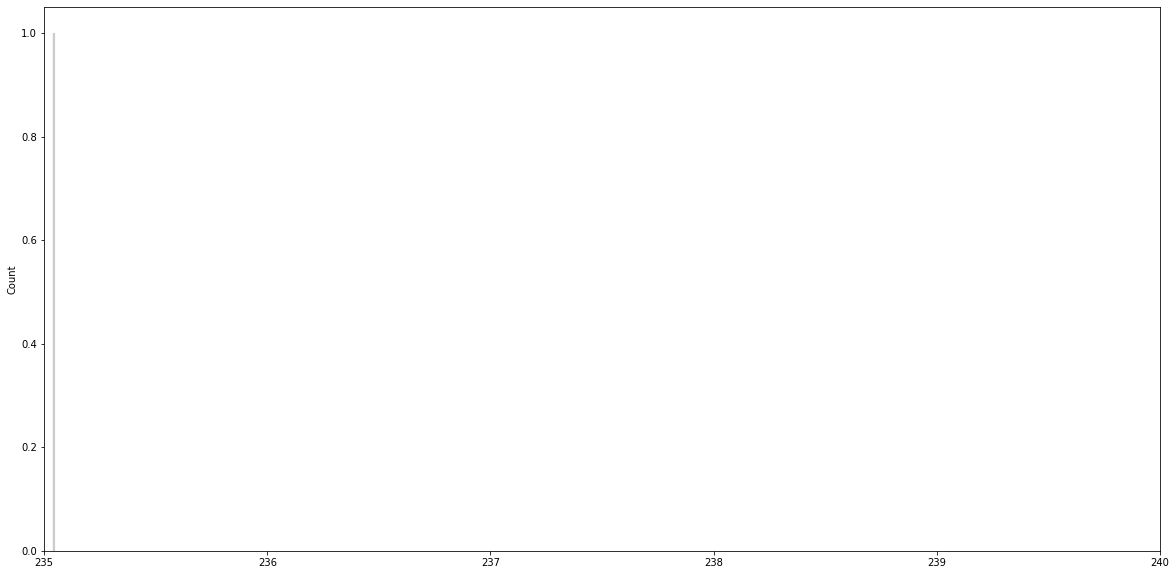

In [21]:
plt.figure(figsize=(20, 10))
arr = np.array(neg_mass_list)
arr = arr[(arr>235)&(arr<255)]
plot = sns.histplot(arr, bins=2000)
plot.set(xlim=(235, 240))
plt.show()

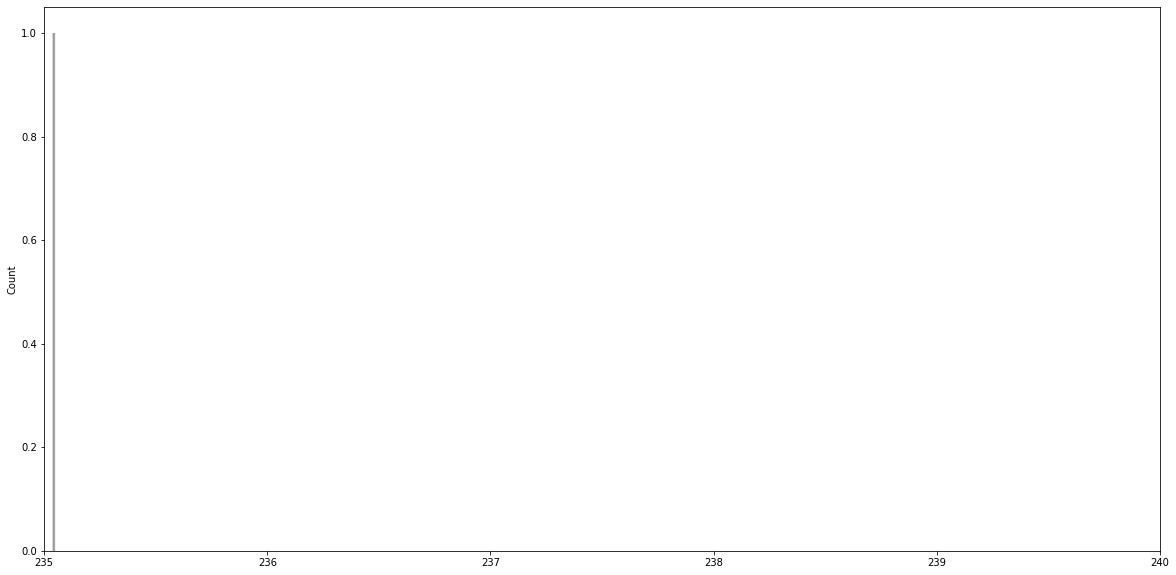

In [22]:
plt.figure(figsize=(20, 10))
arr = np.array(pos_mass_list)
arr = arr[(arr>235)&(arr<255)]
plot = sns.histplot(arr, bins=2000)
plot.set(xlim=(235, 240))
plt.show()

In [23]:
arr = np.array(neg_mass_list)
pd.Series(arr).to_csv('../data/negative_found_masses.csv')

In [24]:
%pycat data_transformation.py

In [25]:
pd.Series(arr[(arr>20) & (arr<400)])

0          20.991271
1          20.991792
2          20.991813
3          20.992146
4          20.992593
             ...    
113833    235.043819
113834    235.044642
113835    235.045096
113836    235.045290
113837    235.046912
Length: 113838, dtype: float64

In [26]:
arr = np.array(mass_list)
arr[(arr>180)&(arr<200)]

array([180.00009498, 180.00047637, 180.00059812, ..., 199.99925505,
       199.99934485, 199.99991647])

In [27]:
def get_similar_peaks(mass_list, thresh=.005):
    '''
    Takes in list of peak mass values and fills a dictionary with similar peaks
    so that we have a record of common peaks. Assumes that the list of peak
    masses is sorted.
    '''
    groups = {}
    for i, number in enumerate(mass_list):
        added = False
        if len(groups.keys()) > 0:
            key = list(groups.keys())[-1]
            if abs(key - number) < thresh:
                added = True
                groups[key].append(number)
                mean = np.mean(groups[key])
                if abs(mean - number) < abs(mean - key):
                    groups[number] = groups[key].copy()
                    del groups[key]
        if not added:
            if (i + 1) < len(mass_list) and abs(mass_list[i + 1] - number) < thresh:
                groups[number] = [number]
    return groups

In [28]:
%%time
groups = get_similar_peaks(mass_list)

CPU times: user 21 s, sys: 553 ms, total: 21.6 s
Wall time: 20.7 s


In [29]:
len(groups[list(groups.keys())[0]])

1049

In [30]:
groups.keys()

dict_keys([1.0068434485385331, 2.0140861671599546, 3.0150202269383115, 6.014864934832586, 7.015560790535634, 9.011122480119779, 10.012320671014955, 11.00816842143966, 11.999008370044587, 13.006843005033453, 14.00481480673581, 14.014845661183152, 14.997713033087432, 15.0030001029649, 15.00998322382968, 15.022908702119873, 15.993157118127831, 16.017464169674785, 16.028382085642505, 16.033494469978926, 17.001002371013886, 17.025294574130495, 17.997933628264057, 18.00901409055465, 18.033289499357082, 18.99784365852821, 19.9902144334329, 20.991813023982953, 21.99094145397731, 22.988984013755484, 23.984529171052014, 23.99879464560183, 24.984744741279833, 25.005912384890436, 25.980790706208502, 26.00230447270856, 26.01391500679877, 26.97968971275288, 27.007946400863737, 27.013638724637467, 27.021856900042362, 27.97476336308875, 27.97981273913772, 27.987811533048607, 27.9931457292004, 28.007947018829874, 28.018749420724063, 28.029413882031893, 28.975711225718268, 28.983314761626755, 29.0016569

In [31]:
df_test = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in groups.items() ]))

In [32]:
df_test.to_csv('../data/df_of_peak_groups_only_unfound_peaks.csv', index=False)

In [33]:
df_test.head()

,1.006843,2.014086,3.015020,6.014865,7.015561,9.011122,10.012321,11.008168,11.999008,13.006843,14.004815,14.014846,14.997713,15.003000,15.009983,15.022909,15.993157,16.017464,16.028382,16.033494,17.001002,17.025295,17.997934,18.009014,18.033289,18.997844,19.990214,20.991813,21.990941,22.988984,23.984529,23.998795,24.984745,25.005912,25.980791,26.002304,26.013915,26.979690,27.007946,27.013639,...,202.022764,202.028227,202.036952,202.050758,202.062147,202.074883,202.082895,202.092229,202.098711,202.106996,202.117995,202.123542,202.132802,202.140355,202.146056,202.154360,202.166216,202.176635,202.182714,202.191218,202.206224,202.215637,202.970868,203.970838,204.972293,205.972804,206.974279,207.029931,207.034994,207.974760,208.982249,212.935343,212.940707,221.081872,221.087809,223.028293,223.969171,223.974306,232.037731,235.041968
0,1.004886,2.011105,3.013430,6.013252,7.013033,9.010999,10.010428,11.006436,11.997006,13.000360,14.000086,14.012642,14.997190,15.002763,15.008018,15.020466,15.991912,16.015713,16.028282,16.033388,16.996294,17.023533,17.996233,18.007561,18.031375,18.995401,19.989410,20.991178,21.990263,22.986774,23.982014,23.997002,24.982850,25.004821,25.979610,26.000087,26.012643,26.978546,27.007891,27.012951,...,202.022275,202.028133,202.034988,202.046240,202.058692,202.071149,202.082399,202.088216,202.097884,202.105196,202.116384,202.123000,202.129642,202.140188,202.145382,202.152509,202.165269,202.176311,202.181851,202.189437,202.203131,202.215637,202.969330,203.970058,204.971541,205.971503,206.974081,207.029794,207.034979,207.973725,208.977505,212.935248,212.940507,221.081826,221.086905,223.024725,223.969023,223.974221,232.035184,235.040950
1,1.004893,2.011270,3.014861,6.013486,7.013220,9.011122,10.010911,11.006523,11.997032,13.000360,14.000349,14.012645,14.997206,15.002963,15.008028,15.020477,15.991912,16.015722,16.028288,16.033494,16.996297,17.023541,17.996324,18.007564,18.031439,18.995430,19.989533,20.991271,21.990754,22.986810,23.982099,23.997006,24.982900,25.004824,25.979627,26.000126,26.012647,26.978558,27.007894,27.012975,...,202.022709,202.028227,202.035201,202.046453,202.059195,202.071182,202.082467,202.088285,202.098599,202.105447,202.116759,202.123336,202.130125,202.140355,202.145853,202.152526,202.166213,202.176437,202.182672,202.189800,202.203651,202.215715,202.969506,203.970838,204.971724,205.971547,206.974261,207.029800,207.034993,207.973739,208.977968,212.935319,212.940699,221.081870,221.087031,223.024809,223.969109,223.974306,232.035225,235.041039
2,1.004980,2.011503,3.015020,6.013875,7.013427,9.011526,10.011243,11.006651,11.997056,13.000376,14.000358,14.012649,14.997257,15.003000,15.008036,15.020495,15.991916,16.015745,16.028295,16.033494,16.996333,17.023585,17.996341,18.007575,18.031487,18.995434,19.990139,20.991792,21.990941,22.986816,23.982129,23.997011,24.982956,25.004825,25.979679,26.000132,26.012648,26.978591,27.007901,27.012988,...,202.022764,202.028321,202.035327,202.046837,202.059208,202.071186,202.082605,202.092224,202.098711,202.106561,202.117865,202.123542,202.130350,202.140456,202.146056,202.152623,202.166216,202.176592,202.182714,202.190319,202.204349,202.216518,202.970446,203.971011,204.972117,205.971680,206.974279,207.029890,207.034994,207.974232,208.978311,212.935343,212.940707,221.081872,221.087145,223.024925,223.969171,223.974339,232.035787,235.041424
3,1.004994,2.011621,3.015315,6.014016,7.013520,9.011850,10.011258,11.006794,11.997093,13.000397,14.000723,14.012650,14.997389,15.003056,15.008049,15.020519,15.991930,16.015774,16.028322,16.033534,16.996335,17.023649,17.996347,18.007595,18.031503,18.995441,19.990214,20.991813,21.992594,22.986833,23.982150,23.997011,24.983217,25.004835,25.979705,26.000150,26.012650,26.978613,27.007905,27.012991,...,202.022901,202.028468,202.035952,202.047214,202.059377,202.071265,202.082766,202.092229,202.098830,202.106770,202.117995,202.124299,202.131291,202.140492,202.146173,202.152701,202.166300,202.176635,202.183146,202.190988,202.205291,NaN,202.97

In [34]:
num_nulls = df_test.isnull().sum()
num_nulls.sort_values(inplace=True)

In [35]:
null_db = num_nulls.reset_index()

In [36]:
null_db.loc[0]['index']

14.014845661183152

In [37]:
np.mean(groups[null_db.loc[0]['index']])

14.0155365201356

In [38]:
groups[null_db.loc[0]['index']]

[14.012641501631332,
 14.012645178164494,
 14.012648999598456,
 14.01264996461094,
 14.012660852793667,
 14.012661579541376,
 14.01266485410743,
 14.01267461378911,
 14.012677969615842,
 14.012678080056448,
 14.012683629893669,
 14.012690927039879,
 14.01269390426707,
 14.012695149438544,
 14.012706729827327,
 14.012711065485943,
 14.012718418688001,
 14.012719902364518,
 14.012730571176972,
 14.012731314385501,
 14.01273752092988,
 14.01274292230154,
 14.012745289708205,
 14.012746531609219,
 14.012758553346877,
 14.012764330619218,
 14.012768038877944,
 14.012769515017816,
 14.012776423977757,
 14.012779743554047,
 14.012790787885928,
 14.01280321409138,
 14.012826113852467,
 14.012827688236797,
 14.012844024057985,
 14.012845839015807,
 14.012850628186856,
 14.012858549727737,
 14.012861634804281,
 14.012863293691224,
 14.012863442324889,
 14.012874982918971,
 14.012878502616724,
 14.012886536653355,
 14.012911395935605,
 14.012932969356108,
 14.012937422406667,
 14.012944709450277,

In [39]:
len(groups[null_db.loc[0]['index']])

2395

In [40]:
fragment_df.loc[510:520]

,FragmentMass,FragmentLabel,Isotopes,Formula,FragmentID,occurrences,negative_occurence_rate,positive_occurence_rate
510,79.01430,H3N2O3,1H3 14N2 16O3,H3+N2+O3,511,105,0.371425,0.628565
511,79.01703,C3HN3,12C3 1H1 14N3,C3+H+N3,512,187,0.572189,0.427805
512,79.01836,C5H3O,12C5 1H3 16O1,C5+H3+O,513,272,0.503675,0.496322
513,79.02687,CH5NO3,12C1 1H5 14N1 16O3,C+H5+N+O3,514,91,0.318678,0.681311
514,79.02960,C4H3N2,12C4 1H3 14N2,C4+H3+N2,515,69,0.420284,0.579702
515,79.03811,H5N3O2,1H5 14N3 16O2,H5+N3+O2,516,86,0.220928,0.779061
516,79.04217,C5H5N,12C5 1H5 14N1,C5+H5+N,517,96,0.260414,0.739576
517,79.91640,Kr,80Kr1,80Kr,518,10,0.099990,0.899910
518,79.91650,Se,80Se1,Se,519,13,0.461503,0.538420
519,79.95680,SO3,32S1 16O3,S+O3,520,391,0.820970,0.179028


In [41]:
fragment_df[fragment_df['FragmentLabel'] == 'H']

,FragmentMass,FragmentLabel,Isotopes,Formula,FragmentID,occurrences,negative_occurence_rate,positive_occurence_rate
0,1.00782,H,1H1,H,1,1049,0.400381,0.599618
1,2.01410,H,2H1,2H,2,1019,0.389597,0.610402


In [42]:
12 * 6 + 1.00782* 7

79.05474

In [43]:
df.head()

,file_name,MassOverTime,MassOffset,StartFlightTime,SpecBinSize,channels,intensities,masses,adjusted_original_proportion_identified,avg_dist_frags_low,avg_dist_frags_high,adjusted_proportion_identified,proportion_identified,diff,prop_diff_in_low,calibration,technique
0,C0059-V1.csv,1.690970,0.708925,0.0,0.128,"[12729.6134, 13388.07292, 14021.38724, 14625.2...","[10106.0, 32018.0, 4303.0, 816.0, 44497.0, 346...","[12.000516134304917, 13.00825496659651, 14.015...",0.307692,0.000930,0.001400,0.538462,0.515789,0.000470,0.504991,0,0
1,C0060-V1.csv,1.686650,0.706374,0.0,0.128,"[12773.45818, 13433.49441, 13495.05187, 14068....","[37242.0, 67973.0, 112.0, 5361.0, 4489.0, 2193...","[11.999648578820876, 13.007180420340381, 13.10...",0.409091,0.000994,0.001364,0.562937,0.542088,0.000370,0.372432,1,0
2,C0061-U1.csv,1.684820,0.708105,0.0,0.128,"[12779.34033, 13440.22492, 14076.03163, 14689....","[483.0, 782.0, 1374.0, 2985.0, 152.0, 302.0, 3...","[11.999700337252365, 13.007438841283296, 14.01...",0.428571,0.001181,0.001583,0.575188,0.558394,0.000402,0.340298,1,1
3,C0061-V1.csv,1.690380,0.708417,0.0,0.128,"[1381.98178, 1400.517, 1412.53457, 1440.11759,...","[2675.0, 1381.0, 674.0, 196.0, 93.0, 50539.0, ...","[1.014923540233473, 1.0230201316204572, 1.0282...",0.305155,0.001156,0.001566,0.381443,0.302288,0.000410,0.354811,0,0
4,C0062-U1.csv,1.683051,0.707803,0.0,0.128,"[12795.06881, 13456.57005, 14092.96684, 14707....","[565.0, 835.0, 1243.0, 2532.0, 99.0, 220.0, 14...","[12.0010393218355, 13.008711984543739, 14.0164...",0.427509,0.001284,0.001697,0.609665,0.605166,0.000412,0.321084,1,1


In [45]:
indices = []
for i, row in enumerate(df.itertuples()):
    unfound, found = get_unmatched_peaks(row.masses, frags)
    for mass in unfound:
        if 31 - mass > -.1 and 31 - mass < 0.01:
            indices.append(i)

In [44]:
frags

0         1.007820
1         2.014100
2         3.016029
3         4.002603
4         6.015120
           ...    
4471    221.084810
4472    223.027690
4473    223.971500
4474    232.038100
4475    235.043933
Name: FragmentMass, Length: 4476, dtype: float64

In [47]:
len(indices)

677

In [50]:
phosphorous_issues = df.loc[indices].copy().reset_index(drop=True)

In [51]:
from data_transformation import (get_isotope_data, get_ranges,
                                 get_suspicious_peaks, get_peak_suspiciousness)
isotopes = get_isotope_data()
ranges = get_ranges(isotopes['Isotope Masses'], 2000)
suspicious_peaks = phosphorous_issues['masses'].apply(get_suspicious_peaks, args=(ranges, ))
num_sus_peaks = pd.Series(suspicious_peaks).apply(len)
prop_sus_peaks = num_sus_peaks / phosphorous_issues['masses'].apply(len)
peak_susses =  phosphorous_issues['masses'].apply(get_peak_suspiciousness, args=(ranges, ))
avg_peak_sussness = pd.Series(peak_susses).apply(np.mean)

In [52]:
len(phosphorous_issues)

677

In [53]:
len(avg_peak_sussness)

677

In [54]:
phosphorous_issues['avg_NPZ_dist_prop'] = avg_peak_sussness
phosphorous_issues['proportion_NPZ_peaks'] = prop_sus_peaks
phosphorous_issues['num_peaks_NPZ'] = num_sus_peaks

In [55]:
phosphorous_issues.head()

,file_name,MassOverTime,MassOffset,StartFlightTime,SpecBinSize,channels,intensities,masses,adjusted_original_proportion_identified,avg_dist_frags_low,avg_dist_frags_high,adjusted_proportion_identified,proportion_identified,diff,prop_diff_in_low,calibration,technique,avg_NPZ_dist_prop,proportion_NPZ_peaks,num_peaks_NPZ
0,C0063-U1.csv,1.678840,0.705438,0.0,0.128,"[12837.67434, 13500.94552, 14138.66152, 14754....","[644.0, 1091.0, 2378.0, 6425.0, 190.0, 233.0, ...","[12.000305685394032, 13.008119753827005, 14.01...",0.254620,0.001178,0.001589,0.379877,0.335753,0.000411,0.349197,0,1,0.036519,0.134301,74
1,C0066-U1.csv,11.763384,2.235975,0.0,0.128,"[396.99022, 816.91198, 911.24799, 1002.15689, ...","[59.0, 3680.0, 8434.0, 17970.0, 25025.0, 308.0...","[8.030017438592841, 12.013227185771084, 13.018...",0.039216,0.001406,0.002191,0.352941,0.123408,0.000785,0.558154,0,1,0.036413,0.125367,128
2,C0067-U1.csv,11.684350,2.226812,0.0,0.128,"[1014.54153, 1103.32078, 1188.38546, 1351.5309...","[8028.0, 24996.0, 363.0, 895.0, 275.0, 4554.0,...","[14.018710863824278, 15.03062386172052, 16.033...",0.003115,0.001291,0.002006,0.392523,0.208609,0.000715,0.553976,0,1,0.017396,0.049669,30
3,C0069-U1.csv,1.651516,-0.502919,0.0,0.128,"[20080.94604, 20710.02442, 25054.11288, 26502....","[2026.0, 2817.0, 3777.0, 1141.0, 6613.0, 1377....","[14.003113114286865, 15.016065168402244, 22.97...",0.517241,0.001531,0.002269,0.672414,0.672414,0.000738,0.481840,1,1,0.000355,0.000000,0
4,C0070-V1.csv,3.301541,-0.275936,0.0,0.128,"[9102.24592, 9187.00723, 9219.08905, 9256.5901...","[227.0, 878034.0, 233.0, 292.0, 8253.0, 572.0,...","[12.749525404956009, 13.006608938000502, 13.10...",0.386364,0.001680,0.002626,0.446970,0.430657,0.000946,0.563020,0,0,0.075976,0.248175,34


In [56]:
np.mean(phosphorous_issues['num_peaks_NPZ'])

134.27474150664696

In [57]:
np.mean(phosphorous_issues['proportion_NPZ_peaks'])

0.14345101118578688